## Lesson 1: Motivation

< Slides >

## Lesson 2: LangGraph Studio?

< TBD > 

## Lesson 3: The Simplest Graph

Let's build a simple 3 step graph:

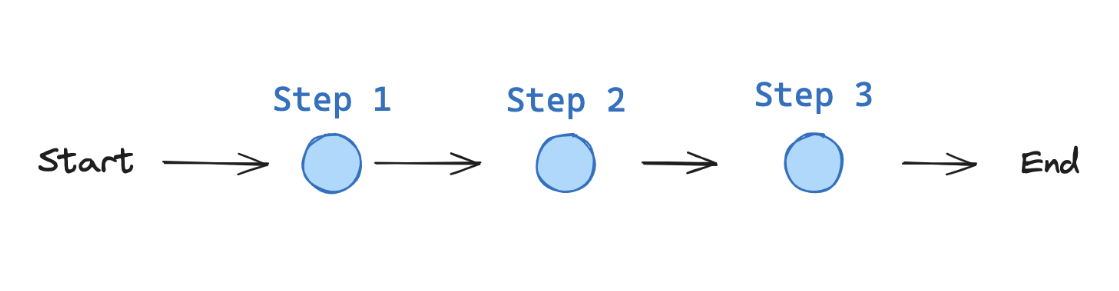

### Graph Definition

`State Definition:`
* Initialize graph (StateGraph) by passing state schema 
* Here, state schema is a TypedDict with a single 'input' field
* Represents the shared data structure for the graph

`Node Functions:`
* Three functions defined: step_1, step_2, step_3
* Each function represents a node in the graph
* Functions take state as input and print a step message

`Graph Construction:`
* Initializes StateGraph with the State class
* Adds nodes using add_node() method
* Creates edges using add_edge() method
* Linear structure: START -> step_1 -> step_2 -> step_3 -> END
* Uses special START and END nodes for entry and exit points

`Graph Compilation:`
* Compiles the graph using builder.compile()
* Performs basic checks on graph structure
* Prepares the graph for execution

`Visualization:`
* Uses built-in visualization capabilities
* Generates and displays a Mermaid diagram of the graph structure

Reference: https://langchain-ai.github.io/langgraph/concepts/low_level/

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph

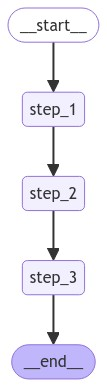

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# State
class State(TypedDict):
    input: str

# Nodes
def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass

# Build graph
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/). protocol, which provides a standard way to execute LangChain components. 

`invoke` is one of the standard methods in this interface, used for synchronous execution.

`Input`
 
* The input is a dictionary {"input":"hello world"}, which matches the State structure defined earlier.
* This input becomes the initial state of the graph execution.

`Execution Process:`
 
* When `invoke` is called, the graph starts execution from the START node.
* It progresses through the defined nodes (step_1, step_2, step_3) in order.
* Each node function receives the current state and can modify it.
* The execution continues until it reaches the END node.

`State Management:`
 
* The initial input state is passed through each node.
* Nodes can read from and write to this state.
* In this simple example, the nodes only print messages, but in a more complex graph, they could modify the state.

`Synchronous Operation:`
 
* `invoke` runs the entire graph synchronously, waiting for each step to complete before moving to the next.

`Return Value:`
 
* The invoke method returns the final state of the graph after all nodes have executed.
* In this case, it would return the state after step_3 has completed.

In [4]:
graph.invoke({"input":"hello world"})

---Step 1---
---Step 2---
---Step 3---


{'input': 'hello world'}

## Lesson 4: Chain

Let's build a simple chain, with only a single step:

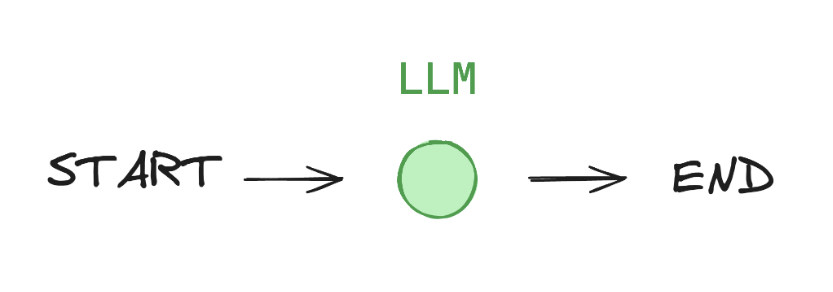

### Graph Definition

`State and Model Definition:`

* Defines State class using TypedDict with 'subject' and 'joke' fields
* Creates Joke class using Pydantic BaseModel for structured output

`LLM Setup:`

* Initializes ChatOpenAI model (GPT-4) for joke generation
* Defines a prompt template for joke generation

`Node Function:`

* Takes the current state
*  Formats the joke prompt with the subject
*  Invokes the LLM with structured output (Joke model)
* Returns the generated joke in the state

`Graph Construction:`

* Initializes StateGraph with the State class
* Adds a single node "generate_joke"
* Defines edges: START -> generate_joke -> END
* Compiles the graph

`Visualization:`

* Generates and displays a Mermaid diagram of the graph structure

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

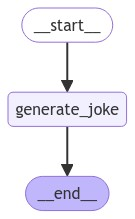

In [13]:
from typing import TypedDict
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START

# Prompt for joke
joke_prompt = """Generate a joke about {subject}"""

# Format for joke
class Joke(BaseModel):
    joke: str

# LLM
model = ChatOpenAI(model="gpt-4o")

# Graph state
class State(TypedDict):
    subject: str
    joke: str

# Here we generate a joke, given a subject
def generate_joke(state):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"joke": [response.joke]}

# Construct the graph
builder = StateGraph(State)
builder.add_node("generate_joke", generate_joke)
builder.add_edge(START, "generate_joke")
builder.add_edge("generate_joke", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"subject":"whales"})

{'subject': 'whales',
 'joke': ["Why don't whales ever get stressed? Because they always keep everything under the sea!"]}

Now, let's extend our chain with a [tool call](https://python.langchain.com/v0.2/docs/how_to/tool_calling/#tool-calls).

Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/).

The [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is quite simple: you can pass any Python function into `ChatModel.bind_tools()`.

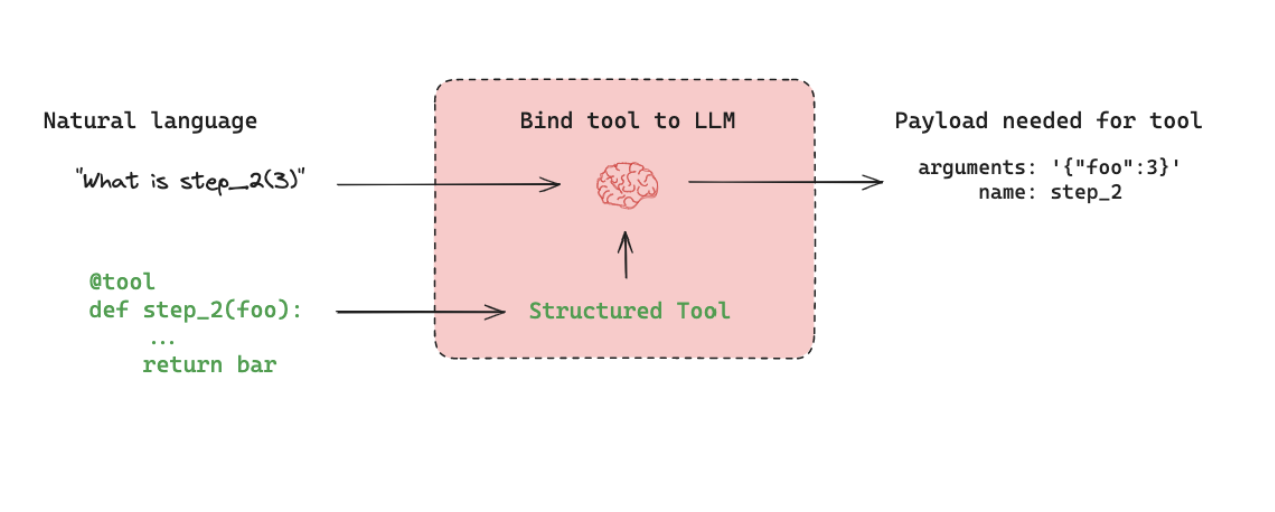

`Tool Definition:`
* Defines `generate_joke` function as a tool
* Uses `ChatOpenAI` model bound with the joke generation tool

`State Definition:`
* Defines `State` class using TypedDict with 'user_input' and 'response' fields

`Node Function:`
* `tool_calling_llm` function:
  - Takes the current state
  - Invokes the LLM with bound tools using the user input
  - Returns the LLM's response in the state

`Graph Construction:`
* Initializes StateGraph with the State class
* Adds a single node "tool_calling_llm"
* Defines edges: START -> tool_calling_llm -> END
* Compiles the graph

We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

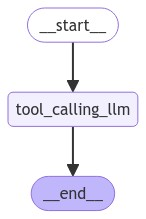

In [37]:
# This will be a tool
def generate_joke(subject: str) -> str:
    """Generate a joke based upon the provided subject"""
    prompt = joke_prompt.format(subject=subject)
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"joke": [response.joke]}

# LLM
llm_with_tools = ChatOpenAI(model="gpt-4o").bind_tools([generate_joke])

# State
class State(TypedDict):
    user_input: str 
    response: str 

# Node
def tool_calling_llm(state: State):
    return {"response": [llm_with_tools.invoke(state['user_input'])]}

# Build grapph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
graph_state = graph.invoke({"user_input":"Tell me a joke about whales"})
graph_state

{'user_input': 'Tell me a joke about whales',
 'response': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rX9hhpFUeYzfuL23S1nZtONb', 'function': {'arguments': '{"subject":"whales"}', 'name': 'generate_joke'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 53, 'total_tokens': 69}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-007ace07-7e1d-4910-b1e6-b426457c47c0-0', tool_calls=[{'name': 'generate_joke', 'args': {'subject': 'whales'}, 'id': 'call_rX9hhpFUeYzfuL23S1nZtONb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 16, 'total_tokens': 69})]}

In [39]:
graph_state['response'][0].tool_calls

[{'name': 'generate_joke',
  'args': {'subject': 'whales'},
  'id': 'call_rX9hhpFUeYzfuL23S1nZtONb',
  'type': 'tool_call'}]

Now, let's simplify our graph by using [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in state.

`Reducer Function:`

* A [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) is a function that determines how updates are applied to a specific key in the state.
* In this case, `add_messages` is the reducer function used for the `messages` key.

`MessageState:`

* `MessagesState` is a [specialized state](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagestate) type designed for handling message-based conversations.
* It's defined as a `TypedDict` with a single key: `messages`.
* The `Annotated` type is used to associate the `add_messages` reducer with the `messages` key.

`add_messages Reducer:`
* This reducer is specifically designed for handling message lists.
* Instead of overwriting the existing messages, it appends new messages to the current list.
* It handles various message formats and ensures proper integration of new messages.

`How the Reducer Works:`
* When a node returns an update like `{"messages": [new_message]}`:
* The `add_messages` reducer is called.
* It takes the existing `messages` list and the new message(s).
* It appends the new message(s) to the existing list.
* This allows for maintaining a conversation history without manually managing the list.
 
`Benefits of Using MessageState:`
* Simplifies state management for conversational applications.
* Automatically handles message appending without explicit list operations.
* Ensures consistent handling of different message types (HumanMessage, AIMessage, ToolMessage, etc.).


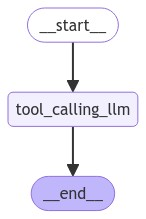

In [56]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

The LLM response is simple appended as the final message!

In [57]:
messages = graph.invoke({"messages": ("user", "Tell me a joke about whales")})
messages['messages'][-1].tool_calls

[{'name': 'generate_joke',
  'args': {'subject': 'whales'},
  'id': 'call_IA7hci2PiJsBGnExH9GweWU8',
  'type': 'tool_call'}]

Now, we can create a tool node that will actually run our tool.

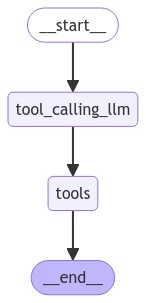

In [59]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools)

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", create_tool_node_with_fallback([generate_joke]))
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", "tools")
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We get a `ToolMessage` back, which is the output of the tool invocation.

In [60]:
messages = graph.invoke({"messages": ("user", "Tell me a joke about whales")})
messages['messages'][-1]

ToolMessage(content='{"joke": ["Why don\'t whales play basketball? Because they\'re afraid of the net!"]}', name='generate_joke', id='d475ec45-4db2-4d08-b5c9-2795a81a032f', tool_call_id='call_fCw8fygz9o70OOg4ePIIfd29')

## Lesson 5: ReAct

ReAct [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/) provides a flexible framework for building agents that can: 

(1) `act` - by calling specific tools 

(2) `observe` - the tool outputs 

(3) `reason` - about the tool output to decide what to do next 

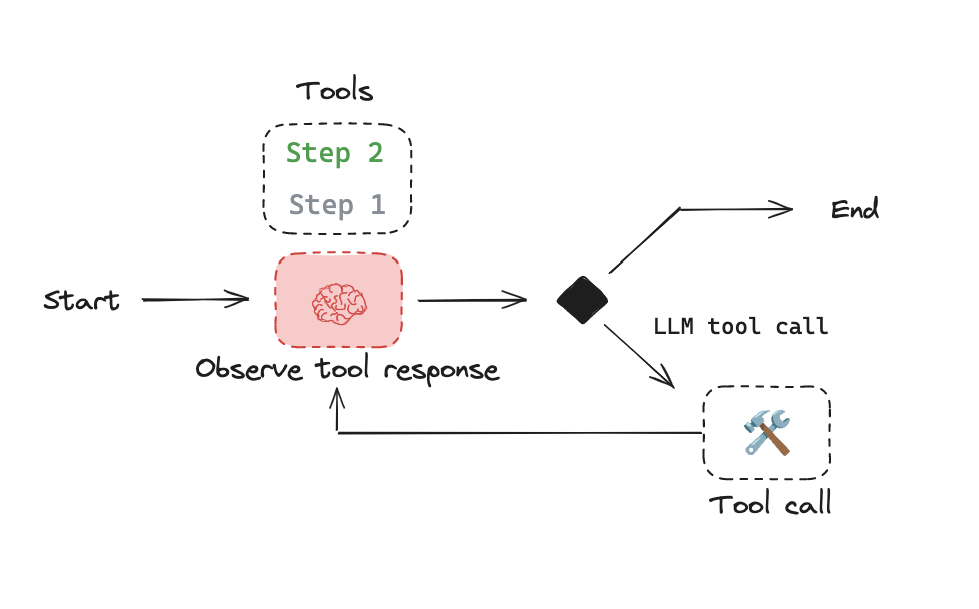

This is a [general purpose cognitive architecture](https://blog.langchain.dev/planning-for-agents/) because it be can applied to any set of tools. 

Let's create a new tool, `generate_story`, and use it with our old tool `generate_joke`.

In [64]:
# Prompt for joke
story_prompt = """Generate a short < 200 word story about {subject}"""

# Format for story
class Story(BaseModel):
    story: str

# LLM
llm = ChatOpenAI(model="gpt-4o")

# This will be a tool
def generate_story(subject: str) -> str:
    """Generate a story based upon the provided subject"""
    prompt = story_prompt.format(subject=subject)
    response = llm.with_structured_output(Story).invoke(prompt)
    return {"story": [response.story]}

tools = [generate_story,generate_joke]

Let's create our LLM and prompt it with the overall agent behavior.

In [65]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke
        """
        result = self.runnable.invoke(state)  
        return {"messages": result}

# Assistant prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with writing jokes or stories. "
         ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

`State Management:`

* Uses `MessagesState`, a TypedDict with a single key 'messages'.
* The 'messages' key is annotated with `add_messages`, a reducer function that appends new messages to the existing list.

`Tools:`
* Defines two tools: `generate_story` and `generate_joke`.
* These tools are bound to the LLM (ChatOpenAI model).

`Assistant:`
* Implements an `Assistant` class that wraps a runnable object (the LLM with bound tools).
* The assistant processes the current state and returns updated messages.

`Graph Structure:`
* Creates a `StateGraph` with two main nodes: "assistant" and "tools".
* The "assistant" node runs the LLM with the current state.
* The "tools" node executes the appropriate tool based on the LLM's output.

`Conditional Edge:`
* Uses `add_conditional_edges` with the `tools_condition` function.
* This is crucial for the ReAct architecture:
* After the "assistant" node executes, `tools_condition` checks if the LLM's output is a tool call.
* If it is a tool call, the flow is directed to the "tools" node.
* If it's not a tool call, the flow is directed to END, terminating the process.

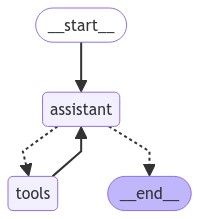

In [66]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

`Flow:`
* Starts at the "assistant" node.
* The assistant generates a response or a tool call.
* If it's a tool call, the flow goes to the "tools" node, which executes the tool.
* After tool execution, it loops back to the "assistant" node.
* This cycle continues until the assistant doesn't make a tool call, at which point it ends.
 
The conditional edge is key to implementing the ReAct architecture. It allows the agent to:
1. Reason about whether to use a tool (in the "assistant" node).
2. Act by calling the tool if needed (routing to the "tools" node).
3. Observe the results (by looping back to the "assistant" node with updated state).
4. Decide when to stop (by not making a tool call, which routes to END).

In [67]:
messages = react_graph.invoke({"messages": ("user", "Tell me a joke about whales")})
messages['messages'][-1]

AIMessage(content="Why don't whales play cards? Because they're afraid of the net!", response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 134, 'total_tokens': 148}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-c8fec53e-01dc-4185-81c4-09858cc40ea8-0', usage_metadata={'input_tokens': 134, 'output_tokens': 14, 'total_tokens': 148})

### Lesson 6: ReAct with Memory

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. 

This limits its ability to have coherent, multi-turn conversations.

`Checkpointer Setup:`

* Creates a [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) using an in-memory database.
* This allows the graph to save its state after each step.
* Compile the graph with the checkpointer, enabling state persistence.

In [72]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
react_graph_memory = builder.compile(checkpointer=memory)

`Configuration Setup:`

* Sets up a configuration with a thread ID.
* This thread ID is crucial for maintaining separate conversation states.

In [73]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Lance."
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Lance.
================================== Ai Message ==================================

Hi Lance! How can I assist you today? Would you like to hear a joke or perhaps a story?


The `Configuration Setup` with thread ID allows us to proceed from the previously logged state.

In [74]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Lance! What can I do for you today? Would you like a joke or a story, perhaps involving your name?


In [76]:
snapshot = react_graph_memory.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Lance.', id='11d60eef-85f9-4096-8b52-bc8d018335e8'), AIMessage(content='Hi Lance! How can I assist you today? Would you like to hear a joke or perhaps a story?', response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 91, 'total_tokens': 114}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-b08d0172-b8df-401f-9dd8-2ad6e51ffd23-0', usage_metadata={'input_tokens': 91, 'output_tokens': 23, 'total_tokens': 114}), HumanMessage(content='Remember my name?', id='817bed30-c5f2-473f-8c3d-db92010e84b8'), AIMessage(content='Of course, Lance! What can I do for you today? Would you like a joke or a story, perhaps involving your name?', response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 125, 'total_tokens': 153}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason'

In [77]:
user_input = "Yes tell me a story about my name!"

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yes tell me a story about my name!
================================== Ai Message ==================================
Tool Calls:
  generate_story (call_buja56SkanQRcPL8J2DBynIX)
 Call ID: call_buja56SkanQRcPL8J2DBynIX
  Args:
    subject: Lance
================================= Tool Message =================================
Name: generate_story

{"story": ["Lance had always been fascinated by the stars. As a child, he would spend hours lying on the grassy hill behind his house, staring up at the night sky. His grandfather had given him an old, battered telescope for his tenth birthday, and from that moment on, Lance was hooked. He dreamed of becoming an astronaut and exploring the cosmos.\n\nYears passed, and Lance's passion for space only grew stronger. He studied astrophysics in college and joined the university's astronomy club. One clear, crisp night, while peering through his telescope, Lance discover

`Overall:`

- The use of a checkpointer (SqliteSaver) allows the graph to maintain state between interactions.
- The thread ID in the config ensures that multiple conversations can be managed separately.
- By using the same thread ID in both interactions, the graph maintains context, allowing for coherent multi-turn conversations.
- The `stream()` method is used instead of `invoke()`, allowing for real-time processing and display of responses.
- The state snapshots (`get_state()`) provide a way to inspect the internal state of the conversation at different points.

In [ ]:
https://python.langchain.com/v0.2/docs/how_to/tool_calling/#tool-calls

In [ ]:
https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements